<a href="https://colab.research.google.com/github/summerolmstead/TextGenerator/blob/main/ML_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#hello this is homework 4 for ML!
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import string

#using the metamorphosis book i have never read it but apparrently about a guy who turns into
#an insect in the middle of the night. chose this as it has a word count of like 20k words roughly.
DATA_DIR = '/content/drive/MyDrive/HW4ML/metamorphosis.book.txt'  #do ur own path here i will put my book's zip file in submission
#changed parameters to capture better patterns
SEQ_LENGTH = 100  # Increased sequence length
HIDDEN_DIM = 1024  # Increased hidden dimension
LAYER_NUM = 4  # Increased number of layers
BATCH_SIZE = 8

#this is all similar to the tutorial's code
data = open(DATA_DIR, 'r', encoding='latin-1').read()

valid_characters = string.ascii_letters + ".,! -'" + string.digits
char_to_int = {ch: i for i, ch in enumerate(valid_characters)}
int_to_char = {i: ch for i, ch in enumerate(valid_characters)}

training_string = ""
for character in data:
    if character in valid_characters:
        training_string += character
    elif character == '\n':
        training_string += ' '

while True:
    if "  " in training_string:
        training_string = training_string.replace("  ", ' ')
    else:
        break

target_string = training_string[1:] + training_string[0]

X = []
y = []
for i in range(0, len(training_string), SEQ_LENGTH):
    training_sequence = training_string[i:(i + SEQ_LENGTH)]
    integer_training_sequence = [char_to_int[value] for value in training_sequence]
    input_sequence = np.zeros((SEQ_LENGTH, len(valid_characters)))
    if len(integer_training_sequence) == SEQ_LENGTH:
        for j in range(SEQ_LENGTH):
            input_sequence[j][integer_training_sequence[j]] = 1.
    X.append(input_sequence)

    y_sequence = target_string[i:(i + SEQ_LENGTH)]
    print(training_sequence, '|', y_sequence)
    y_sequence_ix = [char_to_int[value] for value in y_sequence]
    target_sequence = np.zeros((SEQ_LENGTH, len(valid_characters)))
    if len(y_sequence_ix) == SEQ_LENGTH:
        for j in range(SEQ_LENGTH):
            target_sequence[j][y_sequence_ix[j]] = 1.
    y.append(target_sequence)

X = np.reshape(X, (-1, SEQ_LENGTH, len(valid_characters)))
y = np.reshape(y, (-1, SEQ_LENGTH, len(valid_characters)))

#defining our lstm model in pytorch
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_dim, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out

model = LSTMModel(len(valid_characters), HIDDEN_DIM, LAYER_NUM, len(valid_characters))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#i made a temperature to set the amount of randomness/conservativeness in the generated text
def generate_text(model, length, temperature=1.0):
    model.eval()
    with torch.no_grad():
        ix = torch.randint(len(valid_characters), (1,))
        y_char = [int_to_char[ix.item()]]
        X = torch.zeros((1, length, len(valid_characters)))
        for i in range(length):
            X[0, i, :][ix.item()] = 1
            out = model(X[:, :i + 1, :])
            probabilities = torch.softmax(out[0, i, :] / temperature, dim=0)
            ix = torch.multinomial(probabilities, 1)
            y_char.append(int_to_char[ix.item()])
    return ''.join(y_char)

GENERATE_LENGTH = 20
max_epochs = 36 #lets do 36 which is actually to 35 to get it to the point of understandable sentences
for epoch in range(max_epochs):
    # Shuffle and batch your data here if not already done
    for i in range(0, len(X), BATCH_SIZE):
        batch_X = torch.tensor(X[i:i + BATCH_SIZE], dtype=torch.float32)
        batch_y = torch.tensor(y[i:i + BATCH_SIZE], dtype=torch.float32)

        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output.view(-1, len(valid_characters)), batch_y.view(-1, len(valid_characters)))
        loss.backward()
        optimizer.step()

    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")
        generated_text = generate_text(model, GENERATE_LENGTH, temperature=0.7)
        print(f"Generated Text (Epoch {epoch}): {generated_text}")

print("Completed!") #can see we finally finished our loop!


Output: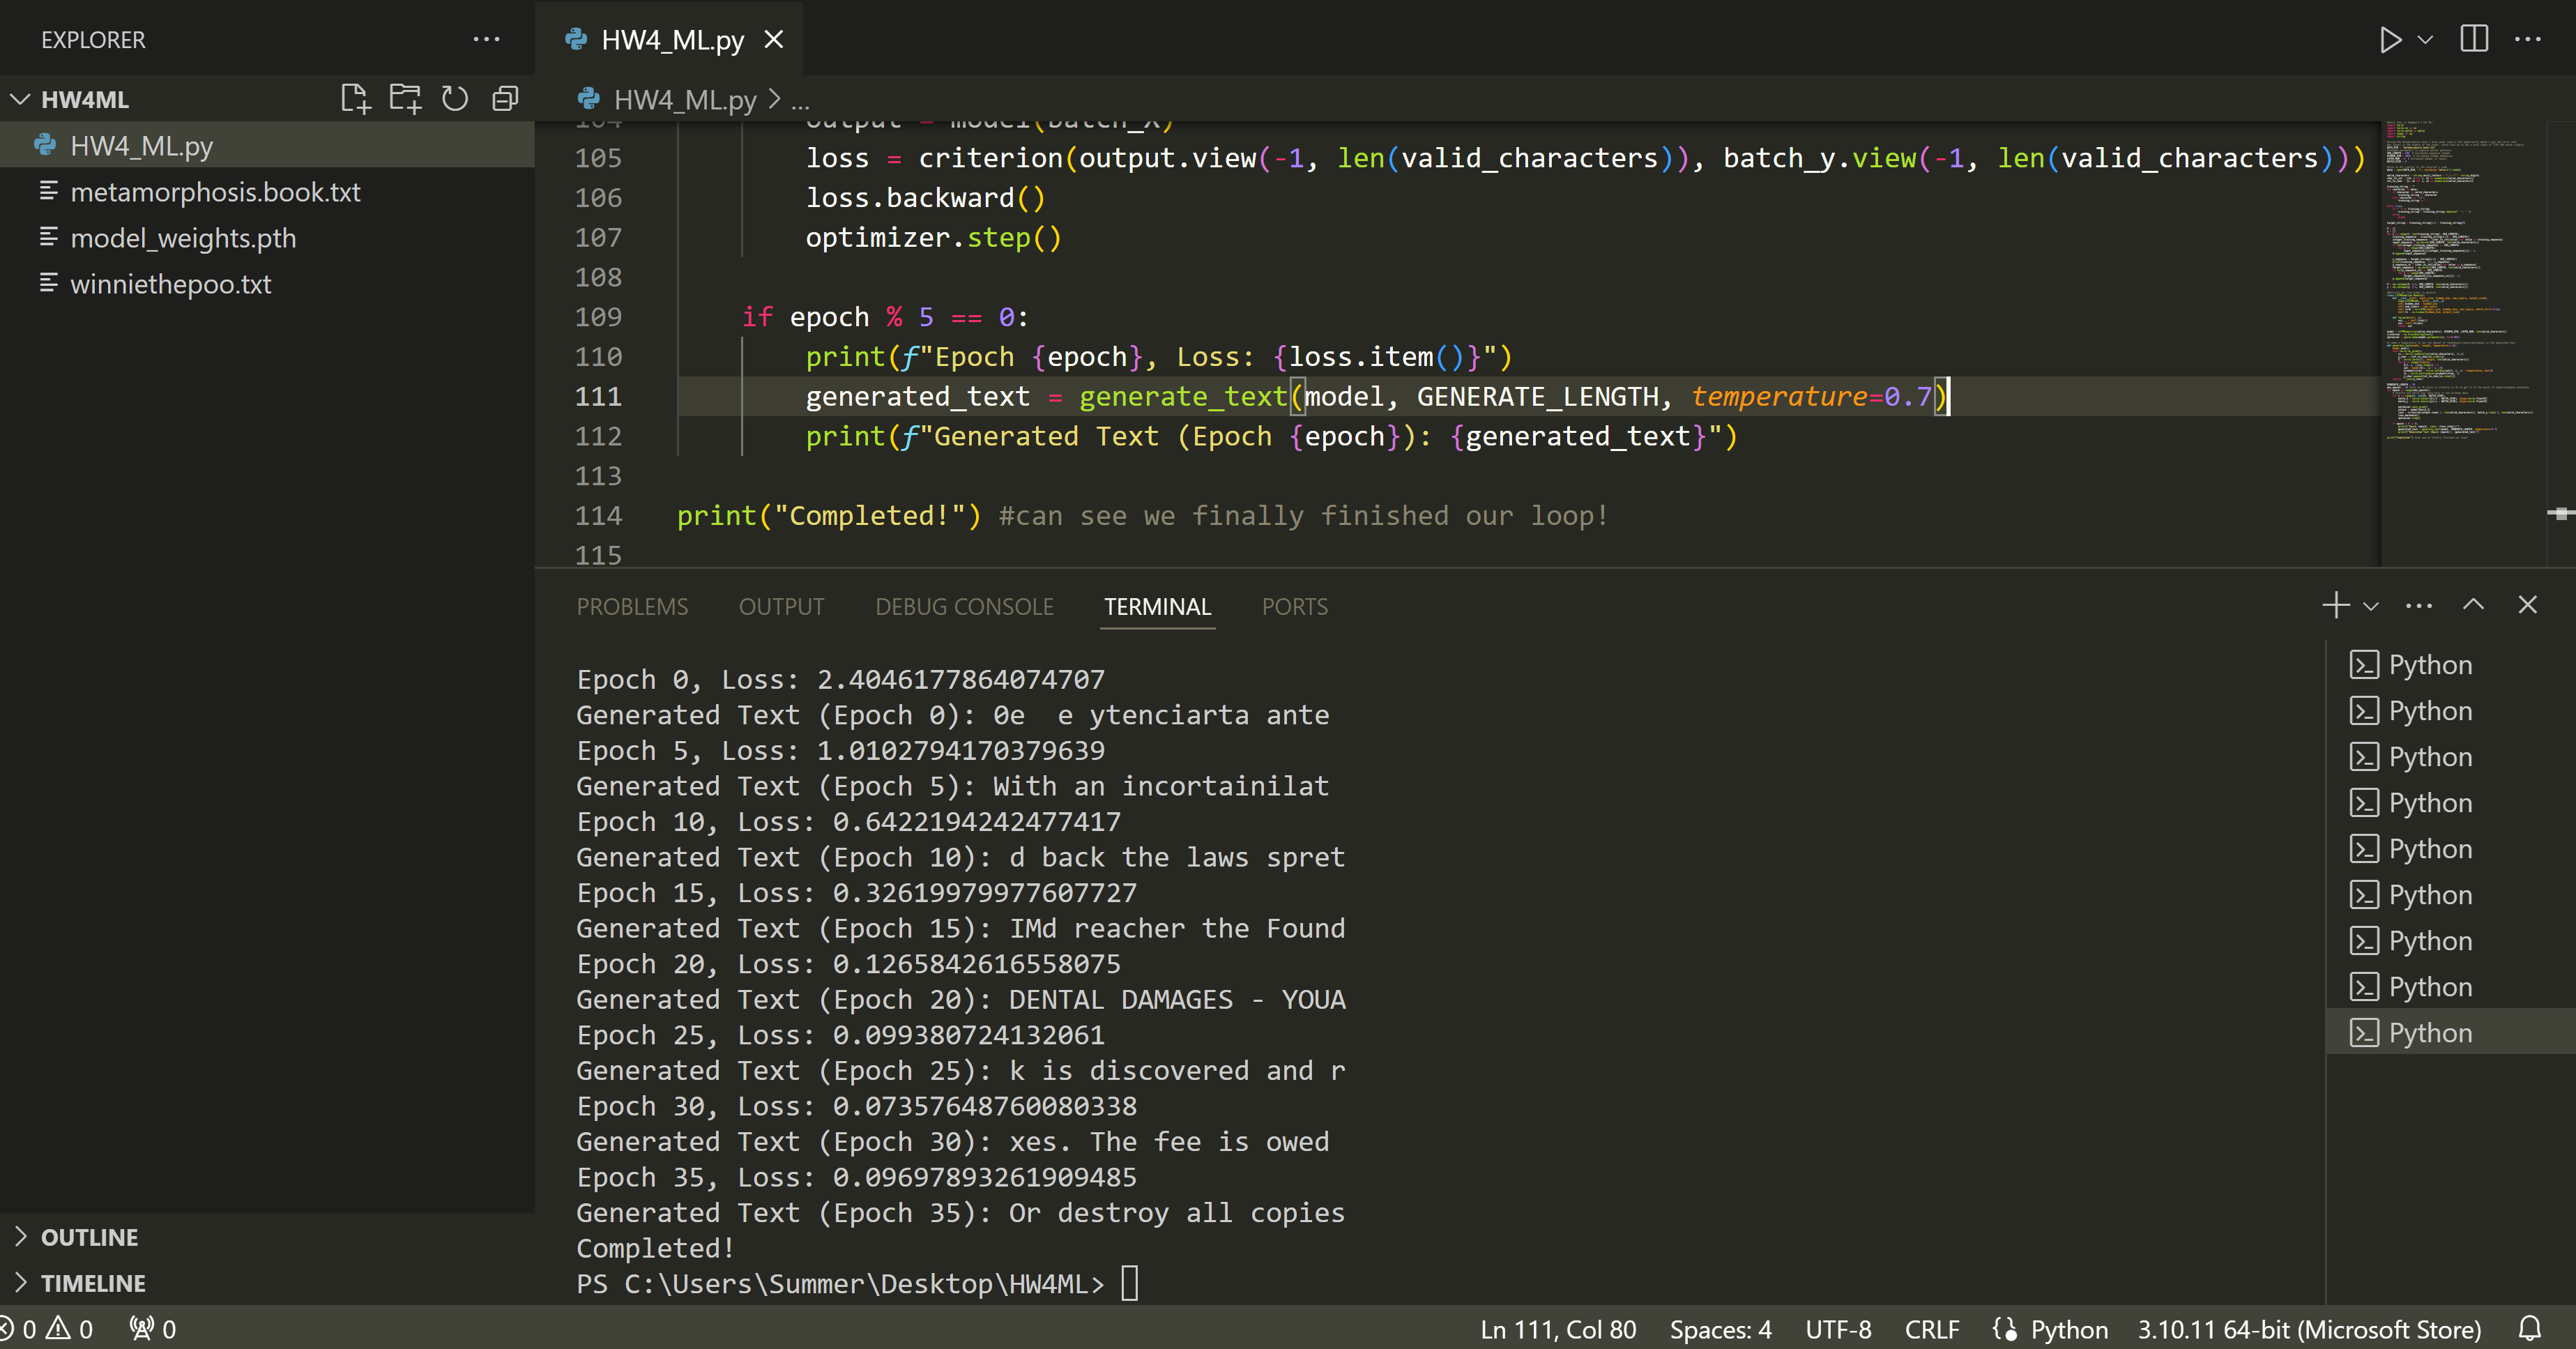

Hello! So i pasted a picture of my output from running this on visual studio code of the result of running this exact code for roughly three hours as it began at 2:30pm and ended running at 5:15pm. While I know we do this on google colab, I had to run it on visual studio because I ran out of RAM on google colab sadly lol and it was jsut taking way longer to run one epoch on here vs visual studio , guessingly because its connected to the cloud and not just in the same folder to run on visual studio code. However, as you can see by epoch 25 we began to have coherent sentences! Great sentence examples are shown in Epoch 30 and 35. This should run on a faster system and have no issues executing on google colab despite me doing it on visual studio code. Thanks for your time and I hope you have interesting text generating after running!